In [1]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

username = 'Andrew_Reusche92'
api_key = '63cd28af853827307d2b6546dd833488'

api_token = {"username":username,"key":api_key}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json



In [2]:
!kaggle datasets download -d ronakgohil/license-plate-dataset

Dataset URL: https://www.kaggle.com/datasets/ronakgohil/license-plate-dataset
License(s): CC0-1.0


In [3]:
!unzip -q license-plate-dataset.zip -d data

In [11]:
pip install scikeras

In [13]:
#import some libraries that may be useful

import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasRegressor

In [17]:
#define the data path
base_path= 'data/archive'
train_img_path= os.path.join(base_path, 'images', 'train')
val_img_path= os.path.join(base_path, 'images', 'val')
train_label_path= os.path.join(base_path, 'labels', 'train')
val_label_path= os.path.join(base_path, 'labels', 'val')

In [20]:
#define the image size we want to transfrom all the image sizes to
img_size= 224 #pixels

In [37]:
#create function to load in the data
def load_data(img_folder, label_folder):
  images= []
  labels= []
  img_files= sorted([f for f in os.listdir(img_folder) if f.endswith('.jpg')])

  for img_file in img_files:

    #load image
    img_path= os.path.join(img_folder, img_file)
    img= cv2.imread(img_path)

    #get original image dimensions
    og_height, og_width, _= img.shape

    #change image color and shape
    img= cv2.resize(img, (img_size, img_size))
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_height, img_width, _= img.shape #image now 224x224 pixels

    #load labels
    label_file= img_file.replace('.jpg', '.txt')
    label_path= os.path.join(label_folder, label_file)
    if os.path.exists(label_path):
      with open(label_path, 'r') as f:

        #read in YOLO format
        line= f.readline().strip().split()

        if len(line) == 5:
          class_id, x_center, y_center, width, height= map(float, line)

          #convert YOLO to absolute pixel value
          x_center *= og_width
          y_center *= og_height
          width *= og_width
          height *= og_height

          #scale coordinates to resized image (224x224)
          scale_x= img_size / og_width
          scale_y= img_size / og_height
          x_center *= scale_x
          y_center *= scale_y
          width *= scale_x
          height *= scale_y

          #convert to coordinates
          x_min= x_center - (width/2)
          y_min= y_center - (height/2)
          x_max= x_center + (width/2)
          y_max= y_center + (height/2)

          #add coordinates and images to lists
          labels.append([x_min, y_min, x_max, y_max])
          images.append(img)

  return np.array(images), np.array(labels)

In [38]:
#load in and split the data

#original training data
train_images, train_labels= load_data(train_img_path, train_label_path)
#validation data
val_images, val_labels= load_data(val_img_path, val_label_path)

#train-test-split the train to make a new test set from 10% of the original train
train_images, test_images, train_labels, test_labels= train_test_split(
    train_images,
    train_labels,
    test_size= 0.1,
    random_state= 24)

#print out the length of each new data subset
print(f'Training set: {len(train_images)} images')
print(f'Validation set: {len(val_images)} images')
print(f'Test set: {len(test_images)} images')

Training set: 1197 images
Validation set: 169 images
Test set: 134 images


## Data Exploration

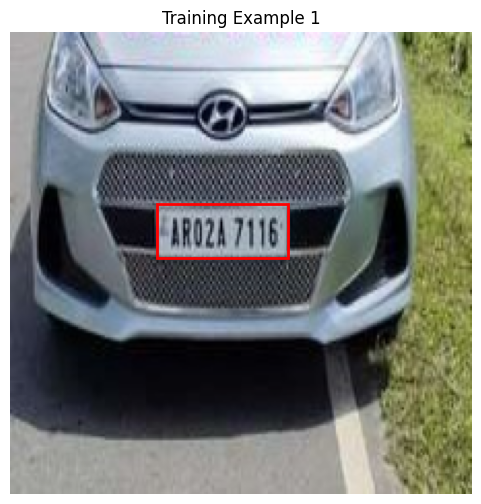

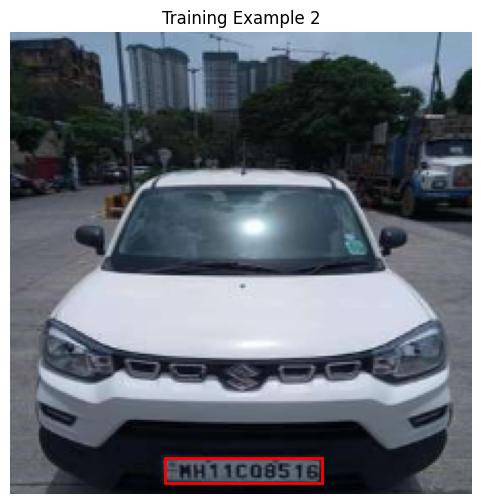

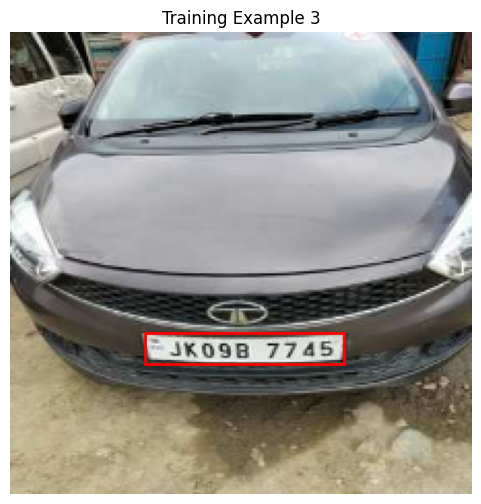

In [39]:
#function to plot training image with bounding box
def plot_image_with_bbox(image, bbox, title= 'image with bounding box'):
  plt.figure(figsize= (6,6))
  plt.imshow(image)
  x_min, y_min, x_max, y_max= bbox
  rect= plt.Rectangle((x_min, y_min),
                      x_max - x_min,
                      y_max - y_min,
                      linewidth= 2,
                      edgecolor= 'r',
                      facecolor= 'none')
  plt.gca().add_patch(rect)
  plt.title(title)
  plt.axis('off')
  plt.show()


  #plot the first three training examples
for i in range(3):
  plot_image_with_bbox(train_images[i],
                         train_labels[i],
                         title= f"Training Example {i+1}")

## Data Preprocessing

In [40]:
#create a fucntion to normalize images and bounding box coordinates
def preprocess_data(images, labels):
  #normalize pixel values
  images= images/255.0
  #normalize bounding box coordinates rlative to image size
  labels= labels/ img_size
  return images, labels

#turn preprocessing into function transformer
preprocess_transformer= FunctionTransformer(lambda X,
                                            y= None: preprocess_data(X,y))


#apply preprocessing to train, val, test datasets
train_images_pp, train_labels_pp= preprocess_transformer.func(train_images,
                                                                   train_labels)
val_images_pp, val_labels_pp= preprocess_transformer.func(val_images,
                                                               val_labels)
test_images_pp, test_labels_pp= preprocess_transformer.func(test_images,
                                                                 test_labels)

## Model Building and Data Analysis

### Baseline Model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - loss: 1.8502 - mae: 0.6181 - val_loss: 0.0658 - val_mae: 0.2149
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - loss: 0.0269 - mae: 0.1273 - val_loss: 0.0387 - val_mae: 0.1644
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - loss: 0.0198 - mae: 0.1070 - val_loss: 0.0348 - val_mae: 0.1549
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - loss: 0.0147 - mae: 0.0928 - val_loss: 0.0328 - val_mae: 0.1484
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - loss: 0.0115 - mae: 0.0813 - val_loss: 0.0290 - val_mae: 0.1386
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - loss: 0.0088 - mae: 0.0704 - val_loss: 0.0317 - val_mae: 0.1452
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - loss: 0.0075 - mae: 0.0656 - val_loss: 0.0276 - val_mae: 0.1351
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 147s 4s/step - loss: 0.0066 - mae: 0.0604 - val_loss: 0.0284 - val_mae: 0.1353
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - loss: 0.005

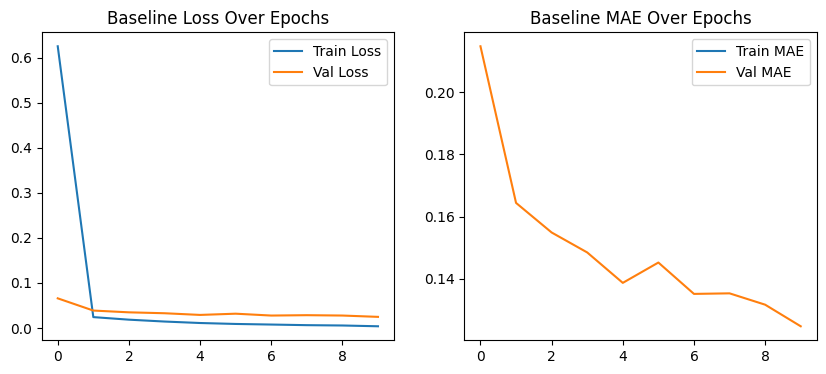

In [44]:
#function to build a baseline CNN Model
def build_baseline_cnn():
  model= models.Sequential([layers.Conv2D(32, (3, 3), activation= 'relu',
                                          input_shape= (img_size, img_size, 3)),
                            layers.MaxPooling2D((2, 2)),
                            layers.Conv2D(64, (3, 3), activation= 'relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Conv2D(128, (3, 3), activation= 'relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Flatten(),
                            layers.Dense(128, activation= 'relu'),
                            layers.Dense(4)])
  optimizer= tf.keras.optimizers.Adam(learning_rate= 0.0001)
  model.compile(optimizer= 'adam', loss= 'mse', metrics= ['mae'])
  return model

#make a function to plot training history
def plot_training_history(history, model_name):
  plt.figure(figsize=(10, 4))

  #plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(history['loss'], label= 'Train Loss')
  plt.plot(history['val_loss'], label= 'Val Loss')
  plt.title(f'{model_name} Loss Over Epochs')
  plt.legend()

  #plot the MAE
  plt.subplot(1, 2, 2)
  plt.plot(history['mae'], label= 'Train MAE')
  plt.plot(history['val_mae'], label= 'Val MAE')
  plt.title(f'{model_name} MAE Over Epochs')
  plt.legend()

  plt.show()

#instantiate the model
baseline_model= KerasRegressor(model= build_baseline_cnn,
                               epochs= 10,
                               batch_size= 32,
                               verbose= 1)


#create a pipeline for preprocessing and basemodel
baseline_pipeline= Pipeline([
    ('b_model', baseline_model)])


#fit the model on the prepocessed data
baseline_model.fit(train_images_pp, train_labels_pp,
                   validation_data= (val_images_pp, val_labels_pp),
                   epochs= 10,
                   batch_size= 32,
                   verbose= 1)

#plot the training history
plot_training_history(baseline_model.history_, model_name= "Baseline")

Evaluate the model


In [42]:
#function to calculate Intersection Over Union (IoU)
def calc_iou(box1, box2):
  x1_min, y1_min, x1_max, y1_max= box1
  x2_min, y2_min, x2_max, y2_max= box2

  x_left= max(x1_min, x2_min)
  x_right= min(x1_max, x2_max)
  y_top= max(y1_min, y2_min)
  y_bottom= min(y1_max, y2_max)

  if x_right < x_left or y_bottom < y_top:
    return 0.0


  intersection= (x_right - x_left) * (y_bottom - y_top)
  area1= (x1_max - x1_min) * (y1_max - y1_min)
  area2= (x2_max - x2_min) * (y2_max - y2_min)
  union= area1 + area2 - intersection

  return intersection/union

#function to visualize predictions with actual vs predicted bounding boxes
def predictions_viz(images, pred_bbs, true_bbs, model_name, num_examples= 3):
  for i in range(num_examples):
    img= images[i].copy()
    pred_bb= pred_bbs[i]
    true_bb= true_bbs[i]
    plt.figure(figsize= (6, 6))
    plt.imshow(img)

    #plot predicted bounding box
    x_min, y_min, x_max, y_max= pred_bb
    rect= plt.Rectangle((x_min, y_min),
                        x_max - x_min,
                        y_max - y_min,
                        linewidth= 2,
                        edgecolor= 'r',
                        facecolor= 'none',
                        label= 'Predicted')
    plt.gca().add_patch(rect)

    #plot actual bounding box
    x_min, y_min, x_max, y_max= true_bb
    rect= plt.Rectangle((x_min, y_min),
                        x_max - x_min,
                        y_max - y_min,
                        linewidth= 2,
                        edgecolor= 'g',
                        facecolor= 'none',
                        label= 'True')
    plt.gca().add_patch(rect)
    plt.title(f"{model_name} Prediction Example {i+1}")
    plt.legend()
    plt.axis('off')
    plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 782ms/step
Baseline Average IoU on Validation set: 0.1059


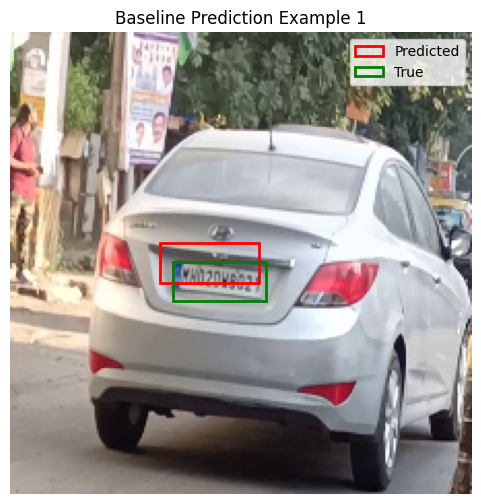

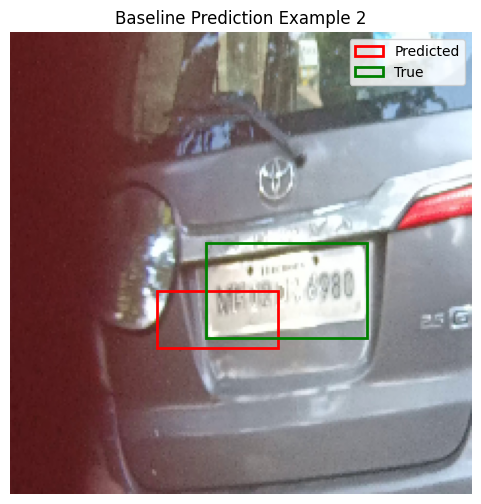

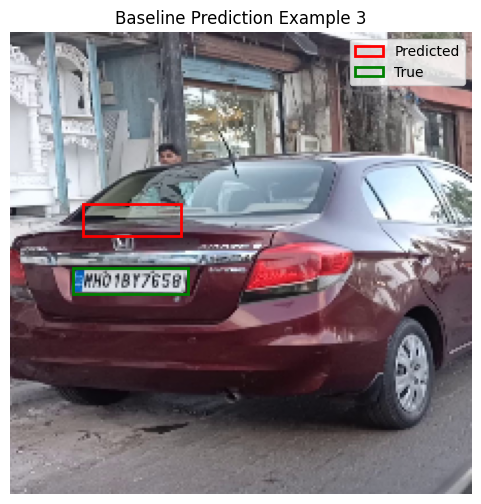

In [45]:
#make predictions on the validation set
val_preds_b= baseline_model.predict(val_images_pp)

#de-normalize predictions and coordinatewd for IoU calculation
val_preds_denorm_b= val_preds_b * img_size
val_labels_denorm_b= val_labels_pp * img_size

#calculate the IoU for each prediction
ious= [calc_iou(val_preds_denorm_b[i], val_labels_denorm_b[i]) for i in range(len(val_preds_b))]
print(f"Baseline Average IoU on Validation set: {np.mean(ious):.4f}")

#show prediction examples
predictions_viz(images= val_images_pp,
                pred_bbs= val_preds_denorm_b,
                true_bbs= val_labels_denorm_b,
                model_name= "Baseline",
                num_examples= 3)



#version 2